In [1]:
import numpy as np
import zarr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import pandas as pd
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.3.5


This notebook analyses Microctonus hyperodae SNP data for the effects of inbreeding in the population of samples overall, and whether there are any systematic differences in inbreeding (Fis and ROH) between different sites and continents. In a sexual species, one would expect the bottleneck caused by an introduction to produce an increase in long tracts of homozygous genotype (aka long runs of homozygosity, or LROH). See:

- https://www.biorxiv.org/content/10.1101/2022.11.25.517957v2.abstract
- https://www.nature.com/articles/s41467-021-25289-w
- https://www.authorea.com/doi/full/10.22541/au.166443132.22937472


In [2]:
#read snps and metadata
zarr_path = '/Users/dennistpw/Projects/microctonus/microctonus_genom/snpdata/microctonus_fullcohort_filtered.zarr/'
callset = zarr.open_group(zarr_path, mode='r')
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['CHROM','POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'QUAL', 'MQRankSum', 'ReadPosRankSum', 'FS', 'SOR' ,'AF'])
df_samples = pd.read_csv('/Users/dennistpw/Projects/microctonus/microctonus_genom/sampledata/myhponly_metadata.csv', index_col = 'order')

start with ROH

In [3]:
#make a dict of scaffolds and lengths
scaflens = {'scaffold_1': 14794116,
'scaffold_2': 11802476,
'scaffold_3': 11182071,
'scaffold_4': 9845951,
'scaffold_5': 9364176,
'scaffold_6': 8268281,
'scaffold_7': 7502216,
'scaffold_8': 6334544,
'scaffold_9': 6331288,
'scaffold_10': 4866973,
'scaffold_11': 4766820,
'scaffold_12': 2747968,}

In [4]:
#enumerate samples
sample_num = np.arange(0, len(df_samples))

In [5]:
#function that takes scaffold and ind id, subsets GT and pos, and infers ROH with poisson HMM 
def calc_roh(chrom, ind):
    chrom
    mask = callset['variants/CHROM'][:]==chrom
    x = allel.GenotypeArray(callset['calldata/GT'])
    scaf_gts = x.compress(mask, axis=0)[:, ind]
    scafpos = callset['variants/POS'][:].compress(mask)
    x = allel.roh_poissonhmm(scaf_gts, scafpos, contig_size=scaflens[chrom])
    return(x)

In [6]:
#iterate over list of samples and chromosomes
#return - a list of dfs per-sample-per-chr with roh info, and a list of total froh for each ind and chr
#- won't run, notebook will read roh output text files, takes around 15-20 mins to run
#%%time
#roh_df_list = []
#froh_list = []
#for num in (sample_num):
#    for chrom in (scaflens.keys()):
#        roh = calc_roh(chrom, num)
#        roh[0]['ind'] = num
#        roh[0]['scaffold'] = chrom
#        roh_df_list.append(roh[0])
#        froh_list.append(roh[1])

In [7]:
froh_list = open('froh_summary_perindperscaf.txt','r').read().split('\n')
froh_list = froh_list[:-1]
roh_df_list = pd.read_csv('froh_byscaf_byind.csv')

In [17]:
#let's work out if there are any differences in froh content by site and continent
#start by working out genomewide froh fr each sample
#create df of inds and scafs
d = pd.DataFrame()
d = []
for num in (sample_num):
    for chrom in (scaflens.keys()):
        d.append(
            {
                'ind_id': num,
                'chrom': chrom,
            }
        )

scaf_roh = pd.DataFrame(d)
#bind froh list and create length of scaffold col by dict lookup of scaffold lengths
scaf_roh['froh'] = froh_list
scaf_roh['scaflength']= scaf_roh['chrom'].map(scaflens)
#number of bases per scaf in ROH
scaf_roh ['froh'] = scaf_roh['froh'].astype(float) #list is read as object so change to float or the notebook will crash when multiplying below
scaf_roh['bases_in_roh'] = scaf_roh['froh'] * scaf_roh['scaflength']
#make df of number of bases in the genome in ROH by grouping by individual and summing the total bases in ROH
genome_in_roh = scaf_roh[['ind_id', 'bases_in_roh']].groupby('ind_id').sum()
#make genomewide fROH by dividing bases in ROH by the sum of scaffold lengths (sum of dict values above)
genome_in_roh['genome_froh'] = genome_in_roh['bases_in_roh'] / sum(scaflens.values())
#join to metadata
samples_withroh = pd.concat([df_samples, genome_in_roh], axis=1)

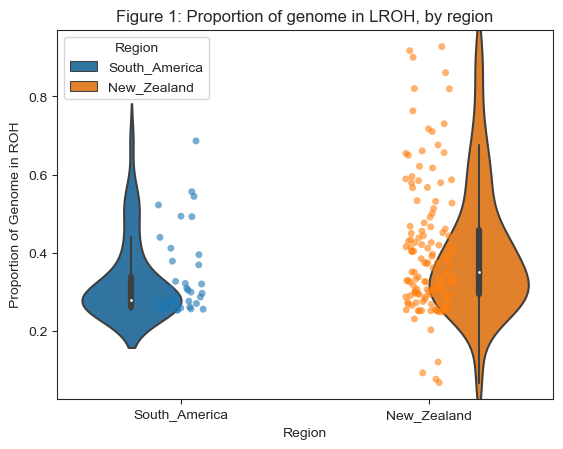

In [19]:
vp1 = sns.violinplot(x="Region", hue="Region", y="genome_froh", data=samples_withroh, showfliers = False)
vp1 = sns.stripplot(x="Region", hue="Region", y="genome_froh", alpha=0.6,data=samples_withroh, legend = False)
vp1 = vp1.set(xlabel ="Region", ylabel = "Proportion of Genome in ROH", title ='Figure 1: Proportion of genome in LROH, by region')

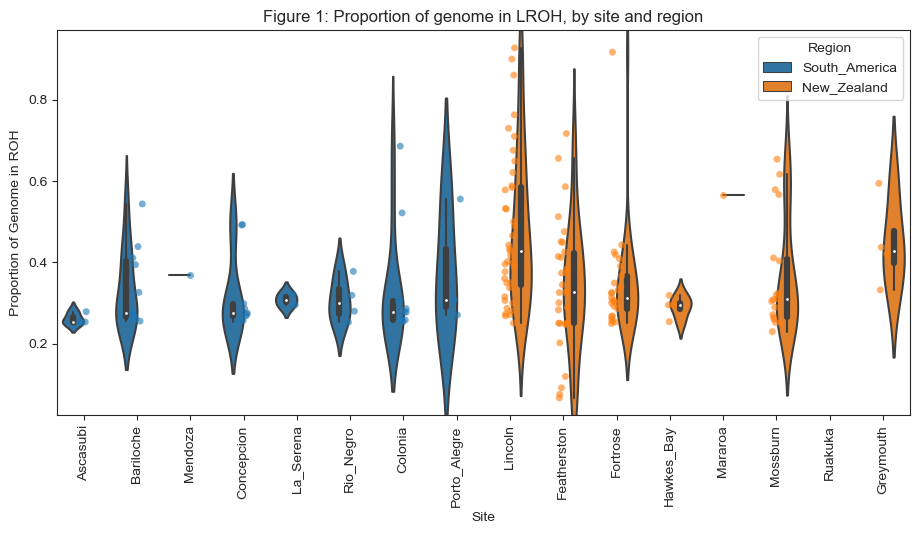

In [20]:
fig, ax = plt.subplots(figsize=(11, 5))
vp2 = sns.violinplot(x="Site", hue="Region", y="genome_froh", 
            order=["Ascasubi","Bariloche","Mendoza","Concepcion", 'La_Serena', 'Rio_Negro', 'Colonia', 'Porto_Alegre', 'Lincoln', 'Featherston', 'Fortrose', 'Hawkes_Bay', 'Mararoa', 'Mossburn', 'Ruakuka', 'Greymouth'],
            data=samples_withroh)
vp2 = sns.stripplot(x = "Site",
              y = "genome_froh",
              hue="Region",
              alpha=0.6,
              legend = False,
              order=["Ascasubi","Bariloche","Mendoza","Concepcion", 'La_Serena', 'Rio_Negro', 'Colonia', 'Porto_Alegre', 'Lincoln', 'Featherston', 'Fortrose', 'Hawkes_Bay', 'Mararoa', 'Mossburn', 'Ruakuka', 'Greymouth'],
              data = samples_withroh)
vp2.tick_params(axis='x', labelrotation=90)
vp2 = vp2.set(xlabel ="Site", ylabel = "Proportion of Genome in ROH", title ='Figure 1: Proportion of genome in LROH, by site and region')

There's something weird going on with the Lincoln samples. The samples look weird on the PCA, and they look weird here. They are also the lowest covered samples. They are among the initially sequenced material.

What happens when I plot coverage here?

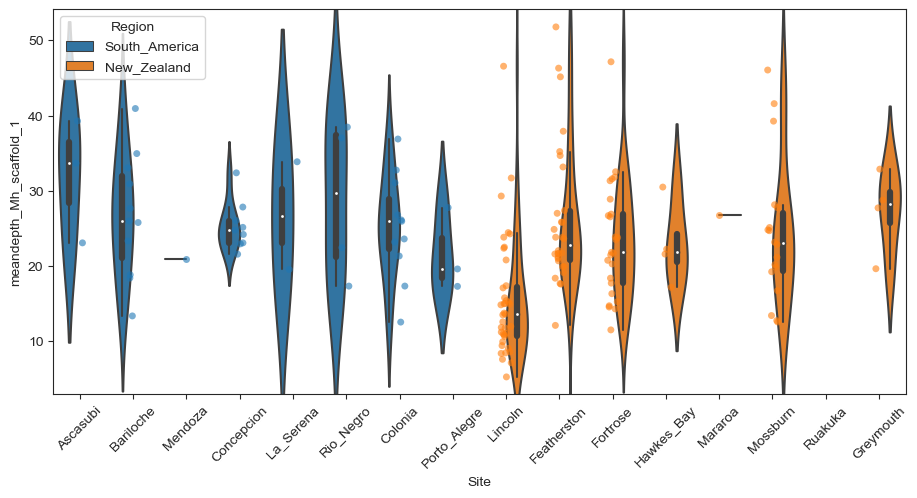

In [21]:
fig, ax = plt.subplots(figsize=(11, 5))
g = sns.violinplot(x="Site", hue="Region", y="meandepth_Mh_scaffold_1", 
            order=["Ascasubi","Bariloche","Mendoza","Concepcion", 'La_Serena', 'Rio_Negro', 'Colonia', 'Porto_Alegre', 'Lincoln', 'Featherston', 'Fortrose', 'Hawkes_Bay', 'Mararoa', 'Mossburn', 'Ruakuka', 'Greymouth'],
            data=samples_withroh)
g = sns.stripplot(x = "Site",
              y = "meandepth_Mh_scaffold_1",
              hue="Region",
              alpha=0.6,
              legend = False,
              order=["Ascasubi","Bariloche","Mendoza","Concepcion", 'La_Serena', 'Rio_Negro', 'Colonia', 'Porto_Alegre', 'Lincoln', 'Featherston', 'Fortrose', 'Hawkes_Bay', 'Mararoa', 'Mossburn', 'Ruakuka', 'Greymouth'],
              data = samples_withroh)
g.tick_params(axis='x', labelrotation=45)

A thought on this - although the breadth of coverage appears generally superb in the exploratory analysis- when we look at sample He/Ho in the exploration, the PCA, and these plots, the lincoln samples consistently look like coverage is affecting them - which makes sense. I'm going to chuck samples with a mean-doc of less than 10, and replot.

In [22]:
samples_over10 = samples_withroh[samples_withroh['meandepth_Mh_scaffold_1'] > 10]
samples_notlincoln = samples_withroh[samples_withroh['Site'] != 'Lincoln']

<AxesSubplot: xlabel='Region', ylabel='genome_froh'>

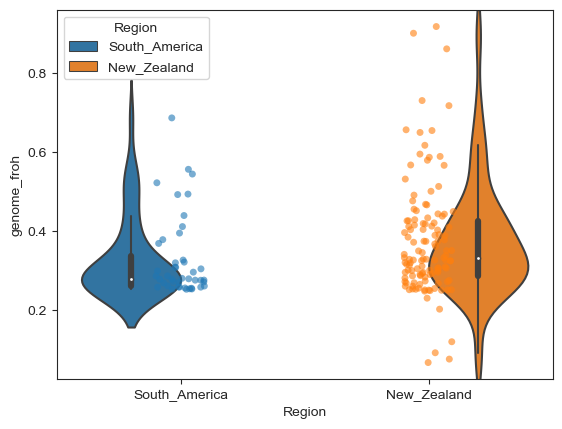

In [23]:
sns.violinplot(x="Region", hue="Region", y="genome_froh", data=samples_over10)
sns.stripplot(x="Region", hue="Region", y="genome_froh", alpha=0.6,data=samples_over10, legend = False)

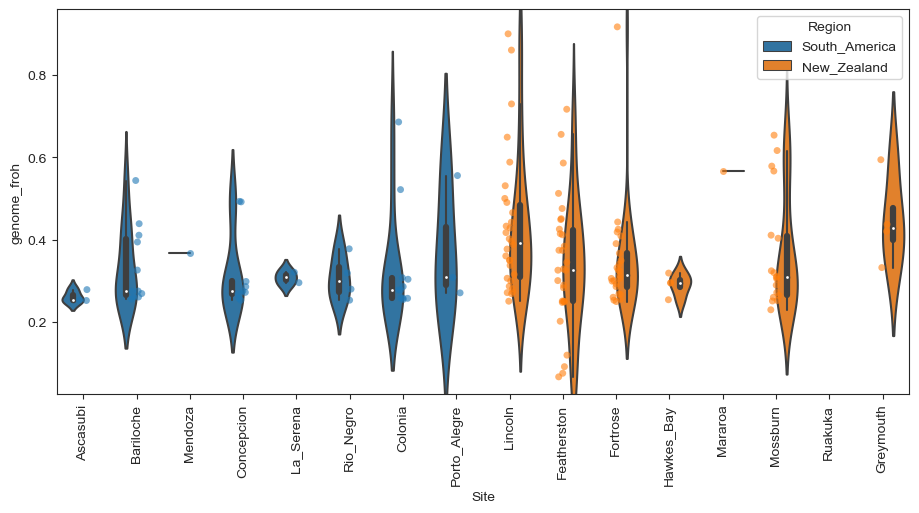

In [24]:
fig, ax = plt.subplots(figsize=(11, 5))
g = sns.violinplot(x="Site", hue="Region", y="genome_froh", 
            order=["Ascasubi","Bariloche","Mendoza","Concepcion", 'La_Serena', 'Rio_Negro', 'Colonia', 'Porto_Alegre', 'Lincoln', 'Featherston', 'Fortrose', 'Hawkes_Bay', 'Mararoa', 'Mossburn', 'Ruakuka', 'Greymouth'],
            data=samples_over10)
g = sns.stripplot(x = "Site",
              y = "genome_froh",
              hue="Region",
              alpha=0.6,
              legend = False,
              order=["Ascasubi","Bariloche","Mendoza","Concepcion", 'La_Serena', 'Rio_Negro', 'Colonia', 'Porto_Alegre', 'Lincoln', 'Featherston', 'Fortrose', 'Hawkes_Bay', 'Mararoa', 'Mossburn', 'Ruakuka', 'Greymouth'],
              data = samples_over10)
g.tick_params(axis='x', labelrotation=90)

First things that jump out are how much of the genome of many of these samples in ROH -some of the lincoln samples have 80% of the genome in long runs of homozygosity - which is enormous for a sexual species but I wonder what this tells us about reproduction. I want to see if these are the same regions because I know in some species of asexual wasp, He and Ho are confined to specific genomic regions that relates to how gamete

The NZ samples are more variable than the SA samples, but I don't see any massive increase in ROH in the NZ samples. I'll do a quick GLM to see how large this effect actually is, but I doubt it will be large or significant. This is interesting - in sexual species this kind of bottleneck would probably lead to an increase in fROH (see refs above) - if we aren't seeing this, is this because of the clonality of the species? If sex isn't leading to variation in he/ho, existing ROH are just being maintained in the introduced population. So, this doesn't seem surprising to me. Perhaps another measure of diversity here would be help.

- I wonder what happens if we plot ROH tracts across the genome - whether we can detect the same regions being dispersed into NZ.
- I wonder about distribution of ROH lengths coming into NZ
- Analysis of IBD segments would be interesting here too. Let's try phasing haps / using ngsF-HMM
- WTF is up with - Lincoln and Featherstone populations?
- We need to sequence more south american wasps
- rerun PCA and ADMIXTURE without the shitty lincoln samples
- ROH GLM

What can we say about whether it was sexual in south america?

In [29]:
summary_roh_df = roh_df_list[['ind', 'length']].groupby('ind').median()
roh_df_list[['ind', 'length']].groupby('ind').min()


,length
ind,
0,175
1,1972
2,967
3,175
4,1972
...,...
177,1999
178,1972
179,175
